# Imports

In [ ]:
from lifelines.plotting import plot_lifetimes
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import h5py
import sys
import os

libs_path = '/media/adalberto/Disk2/PhD_Workspace'
sys.path.append(libs_path)
from data_manipulation.utils import store_data, load_data

## Some simple figure description for the frame

In [ ]:
# Find no treatment cases.
def find_no_treatment_patients(frame_figure):
    cases_list = list()
    cases_nono = list()
    for case_id in np.unique(frame_figure['case_submitter_id'].values):
        comb_pattern = '-'.join(sorted(frame_figure[frame_figure['case_submitter_id']==case_id].treatment_or_therapy.values))
        if comb_pattern == 'no-no':
            cases_nono.append(case_id)
        cases_list.append(comb_pattern)
    return cases_nono, cases_list

# Cohort stats in terms of treatment and stage.
def cases_stats(frame_figure):
    if 'treatment_or_therapy' in frame_figure:
        print(pd.crosstab(frame_figure['treatment_or_therapy'], frame_figure['treatment_type']))
        print()

        cases_nono, cases_list = find_no_treatment_patients(frame_figure)

        fig = plt.figure(figsize=(40,7))
        ax  = fig.add_subplot(151)
        sns.histplot(frame_figure, stat='count', x='treatment_or_therapy', ax=ax)
        ax.set_title('Histogram treatment_or_therapy')
        ax  = fig.add_subplot(152)
        sns.histplot(frame_figure, stat='count', x='treatment_type', ax=ax)
        ax.set_title('Histogram treatment_type')
        ax  = fig.add_subplot(153)
        sns.heatmap(pd.crosstab(frame_figure['treatment_or_therapy'], frame_figure['treatment_type']), ax=ax)
        ax.set_title('Counts treatment_or_therapy - treatment_type')
        ax  = fig.add_subplot(154)
        ax.set_title('Treatment_or_therapy combinations')
        ax.hist(sorted(cases_list))
        cases_list = list()
        for case_id in np.unique(frame_figure['case_submitter_id'].values):
            comb_pattern = '-'.join(sorted(frame_figure[frame_figure['case_submitter_id']==case_id].treatment_type.values))
            cases_list.append(comb_pattern)
        ax  = fig.add_subplot(155)
        ax.set_title('Treatment_or_therapy treatment_type')
        ax.hist(sorted(cases_list))
        plt.show()

        fig = plt.figure(figsize=(50,7))
        ax  = fig.add_subplot(161)
        ax.set_title('All Patients')
        sns.histplot(frame_figure, stat='count', x='months_to_death', ax=ax)
        ax  = fig.add_subplot(162)
        ax.set_title('All Patients')
        sns.histplot(frame_figure, stat='count', x='months_to_last_follow_up', ax=ax)
        ax  = fig.add_subplot(163)
        ax.set_title('All Patients')
        sns.histplot(frame_figure, stat='count', x='event_data', ax=ax, hue='censored')
        ax  = fig.add_subplot(164)
        ax.set_title('No Treatment Patients')
        sns.histplot(frame_figure[frame_figure['case_submitter_id'].isin(cases_nono)], stat='count', x='months_to_death', ax=ax)
        ax  = fig.add_subplot(165)
        ax.set_title('No Treatment Patients')
        sns.histplot(frame_figure[frame_figure['case_submitter_id'].isin(cases_nono)], stat='count', x='months_to_last_follow_up', ax=ax)
        ax  = fig.add_subplot(166)
        ax.set_title('No Treatment Patients')
        sns.histplot(frame_figure[frame_figure['case_submitter_id'].isin(cases_nono)], stat='count', x='event_data', ax=ax, hue='censored')
        plt.show()

# KM plot for the whole cohort and by stage.
def show_KM_plots(frame_figure, project):
    mosaic = '''A'''
    fig = plt.figure(figsize=(10,4), constrained_layout=True)
    ax_dict = fig.subplot_mosaic(mosaic)
    kmf = KaplanMeierFitter(label=project)
    kmf.fit(frame_figure['event_data']/12, event_observed=frame_figure['event_ind'])
    kmf.plot_survival_function(show_censors=True, ax=ax_dict['A'], ci_show=True)
    ax_dict['A'].set_ylim([-0.0,1.05])
    plt.show()

    mosaic = '''AAB'''
    fig = plt.figure(figsize=(16,4), constrained_layout=True)
    ax_dict = fig.subplot_mosaic(mosaic)

    for value in pd.unique(frame_figure.tumor_stage):
        if value == 'not reported': continue
        kmf = KaplanMeierFitter(label=value)
        kmf.fit(frame_figure[frame_figure['tumor_stage']==value]['event_data']/12, event_observed=frame_figure[frame_figure['tumor_stage']==value]['event_ind'])
        kmf.plot_survival_function(show_censors=True, ax=ax_dict['A'], ci_show=True)
    ax_dict['A'].set_title('KM by Stage')
    ax_dict['A'].set_ylim([-0.0,1.05])

    sns.histplot(frame_figure, stat='count', x='tumor_stage', ax=ax_dict['B'])
    plt.show()

# Figure to display KM plots for different train/test sets of folds.
def print_survival_folds(frame_figure, folds):
    sns.set_theme(style='darkgrid')
    fig = plt.figure(figsize=(20,5), constrained_layout=True)
    ax_dict = fig.subplot_mosaic('''01''')
    for i in folds:
        train_patients = [set_[0] for set_ in folds[i]['train']]
        test_patients  = [set_[0] for set_ in folds[i]['test']]
        train_frame = frame_figure[frame_figure.case_submitter_id.isin(train_patients)]
        test_frame  = frame_figure[frame_figure.case_submitter_id.isin(test_patients)]

        kmf = KaplanMeierFitter(label='Fold %i Train Set' % i)
        kmf.fit(train_frame['event_data']/12, event_observed=train_frame['event_ind'])
        kmf.plot_survival_function(show_censors=True, ci_show=False, ax=ax_dict['0'])
        ax_dict['0'].set_title('5 Fold CV Train Sets - Sorted Event Times')
        ax_dict['0'].set_ylim([0,1])
        ax_dict['0'].set_xlim([0,20])

        kmf = KaplanMeierFitter(label='Fold %i Test Set' % i)
        kmf.fit(test_frame['event_data']/12, event_observed=test_frame['event_ind'])
        kmf.plot_survival_function(show_censors=True, ci_show=False, ax=ax_dict['1'])
        ax_dict['1'].set_title('5 Fold CV Test Sets - Sorted Event Times')
        ax_dict['1'].set_ylim([0,1.05])
        ax_dict['1'].set_xlim([0,20])
    plt.show()


# Process data and set assumptions:
    1. Drop columns with all values NaN
    2. Drop column with all same value
    3. Process days to months.
    4. Stage renaming: S1, S2, S3, S4.
    5. Setup columns for 'censored', 'event_ind', 'event_data'.
    6. Drop patients with both death and follow up as NaN.
    7. Drop patients with event data 0.0 (either death and follow up).
    8. Retain the following fields: 'case_submitter_id', 'project_id', 'months_to_death', 'months_to_last_follow_up', 'censored', 'event_ind', 'event_data', 'tumor_stage', 'treatment_or_therapy', 'treatment_type'

In [ ]:
def process_frame_project(frame):
    # 1. Drop columns with all values NaN
    frame = frame.dropna(axis=1, how='all')

    # 2. Drop column with all same value
    frame = frame.drop(columns=['tumor_grade', 'progression_or_recurrence', 'ethnicity', 'gender', 'race', 'classification_of_tumor',
                              'site_of_resection_or_biopsy', 'last_known_disease_status', 'tissue_or_organ_of_origin', 'ajcc_pathologic_m',
                              'ajcc_pathologic_n', 'ajcc_pathologic_stage', 'ajcc_pathologic_t', 'ajcc_staging_system_edition', 'icd_10_code', 'morphology',
                              'primary_diagnosis'])
    # 3. Process days to months.
    frame                             = frame.drop(columns=['days_to_diagnosis']) # Only values -> array([ 0., nan])
    frame['months_to_death']          = frame['days_to_death']/365*12
    frame['months_to_last_follow_up'] = frame['days_to_last_follow_up']/365*12

    # 4. Stage renaming.
    frame['tumor_stage'] = frame['tumor_stage'].replace({'stage ia':  'stage i',   'stage ib':  'stage i'})
    frame['tumor_stage'] = frame['tumor_stage'].replace({'stage iia': 'stage ii',  'stage iib': 'stage ii'})
    frame['tumor_stage'] = frame['tumor_stage'].replace({'stage iiia':'stage iii', 'stage iiib':'stage iii'})
    frame['tumor_stage'] = frame['tumor_stage'].replace({'stage i':'S1', 'stage ii':'S2', 'stage iii':'S3', 'stage iv':'S4'})

    # 5. Setup columns for 'censored', 'event_ind', 'event_data'.
    frame['censored']   = [0]*frame.shape[0]
    frame['event_ind']  = [1]*frame.shape[0]
    filter_alive        = frame['vital_status']=='Alive'
    frame['censored']   = frame['censored'].mask(filter_alive, 1)
    frame['event_ind']  = frame['event_ind'].mask(filter_alive, 0)
    frame['event_data'] = frame['months_to_death']
    frame.loc[frame['event_data'].isnull(), 'event_data'] = frame[frame['event_data'].isnull()]['months_to_last_follow_up'].values
    frame.loc[frame['event_data'].isnull(), 'event_data'] = np.max(frame['event_data'])

    # 6. Drop patients with both death and follow up as NaN.
    frame = frame.dropna(subset=['months_to_death', 'months_to_last_follow_up'], how='all')

    # 7. Drop patients with event data 0.0 (either death and follow up).
    frame = frame[~(frame.event_data==0.0)]

    # 8. Retain the following fields:
    retain_fields = ['case_submitter_id', 'project_id', 'months_to_death', 'months_to_last_follow_up', 'censored', 'event_ind', 'event_data', 'tumor_stage', 'treatment_or_therapy', 'treatment_type']
    frame = frame[retain_fields]

    return frame

def grab_slides_samples(h5_path, tcga_flag=True):
    samples = None
    with h5py.File(h5_path) as content:
        print('Content:', content.keys())
        slides = content['slides'][:].astype(str)
        if 'samples' not in content.keys():
            print('Samples not find in the H5 file. Creating from slide information.')
            if tcga_flag:
                samples = ['-'.join(slide.split('-')[:3]) for slide in slides]

    print()
    print('Slides: ', len(slides))
    print('Samples:', len(samples))

    df = pd.DataFrame(slides, columns=['slides'])
    df['samples'] = samples
    df = df.drop_duplicates(subset=['slides'])

    return  slides, samples, df

# Project

In [11]:
# Workspace path.
main_path = '/media/adalberto/Disk2/PhD_Workspace'

# Path to TCGA clinical data path.
csv_path  = '%s/utilities/files/TCGA/raw/clinical.tsv' % main_path
# TCGA project name.
project   = 'TCGA-LUAD'

# Complete projections file:
# 1. Slides and samples will be grabbed from here.
# 2. These will be used to create the metadata csv file in order to include this information in the H5.
# 3. It will create folds for survival/clustering: The only difference will be that the clustering pickle will use all available slides for clustering, survival will use samples.
h5_complete_path   = '%s/results/BarlowTwins_3/TCGAFFPE_LUADLUSC_5x_60pc_250K/h224_w224_n3_zdim128_filtered/hdf5_TCGAFFPE_LUADLUSC_5x_60pc_he_complete.h5' % main_path

In [12]:

slides, samples, samples_frame = grab_slides_samples(h5_complete_path)
samples_frame

Content: <KeysViewHDF5 ['img_h_latent', 'img_z_latent', 'indexes', 'labels', 'original_set', 'patterns', 'slides', 'tiles']>
Samples not find in the H5 file. Creating from slide information.

Slides:  887682
Samples: 887682


,slides,samples
0,TCGA-73-4677-01Z-00-DX1,TCGA-73-4677
1,TCGA-50-5045-01Z-00-DX1,TCGA-50-5045
2,TCGA-69-7765-01Z-00-DX1,TCGA-69-7765
5,TCGA-55-5899-01Z-00-DX1,TCGA-55-5899
6,TCGA-67-4679-01Z-00-DX1,TCGA-67-4679
...,...,...
870060,TCGA-66-2769-01Z-00-DX1,TCGA-66-2769
870069,TCGA-98-8020-01Z-00-DX1,TCGA-98-8020
870093,TCGA-66-2791-01Z-00-DX1,TCGA-66-2791
870149,TCGA-66-2767-01Z-00-DX1,TCGA-66-2767


In [13]:
# Read clinical data and select a project.
frame_clinical = pd.read_csv(csv_path, sep='\t', na_values='\'--')
frame_project  = frame_clinical[frame_clinical['project_id']==project]

# Process frame to leave only relevant information.
frame_ready = process_frame_project(frame_project)

treatment_type        Pharmaceutical Therapy, NOS  Radiation Therapy, NOS
treatment_or_therapy                                                     
no                                            254                     330
not reported                                   41                      40
yes                                           170                      95



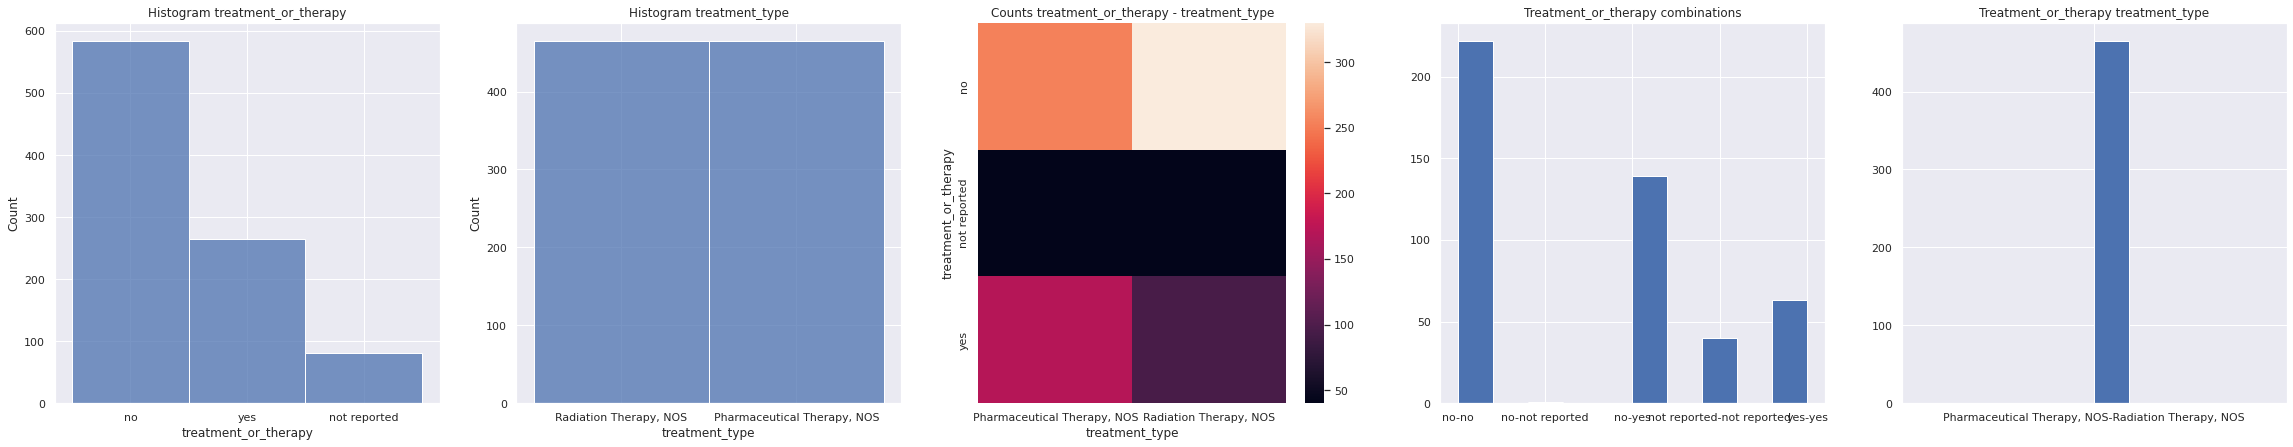

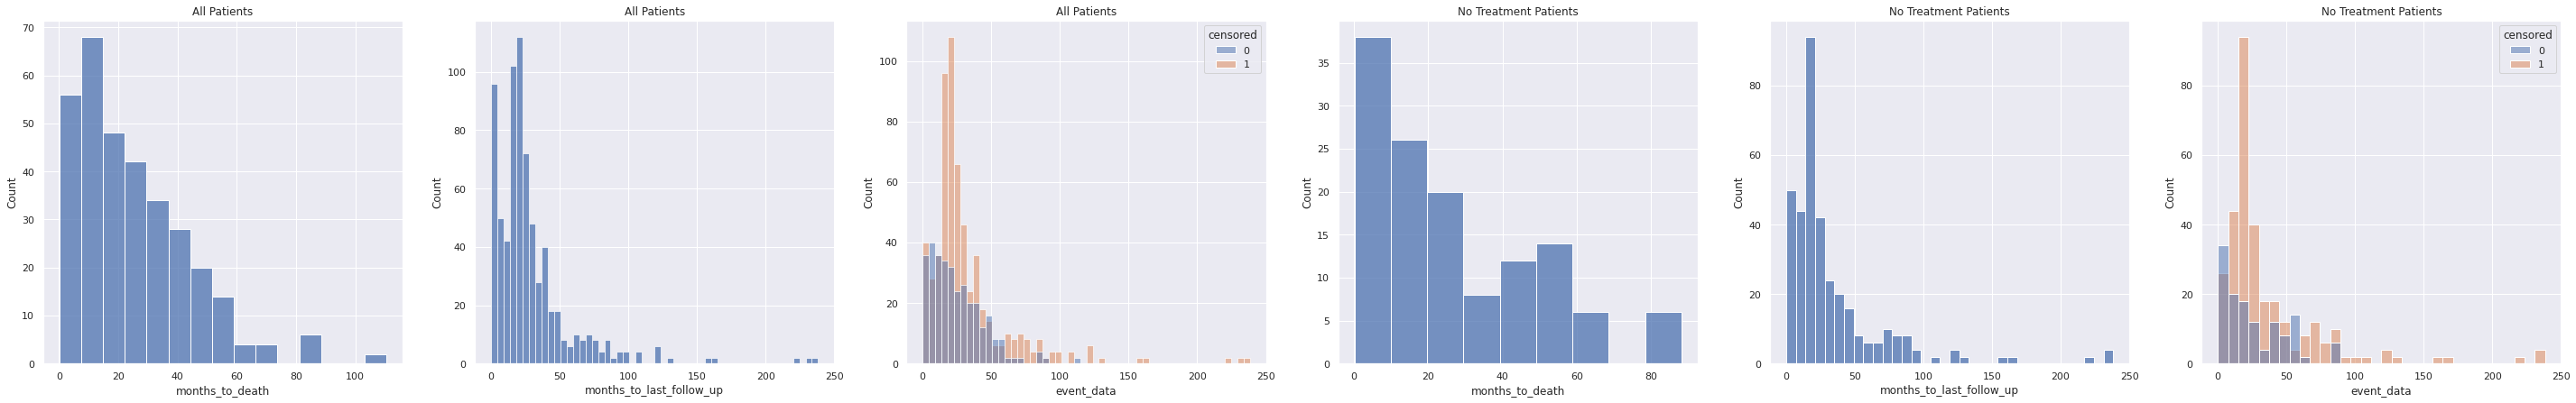

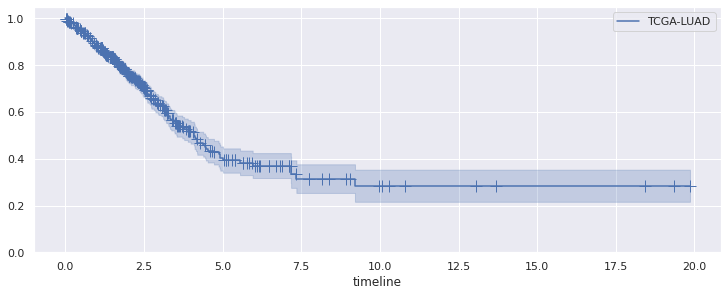

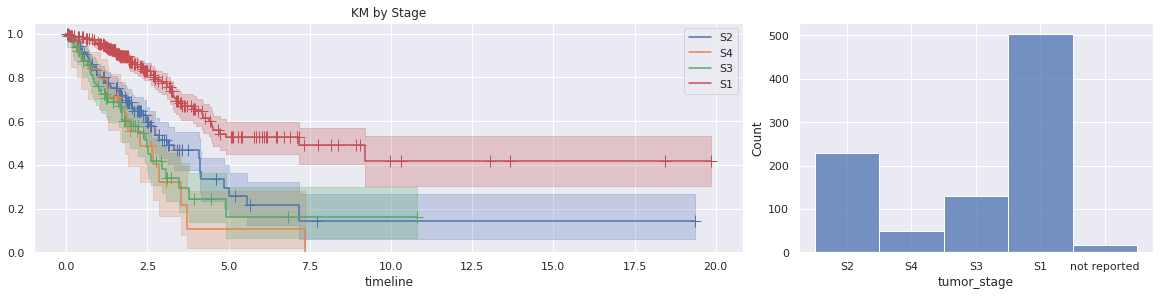

In [14]:
sns.set_theme(style='darkgrid')

# Show stats for treatment and type.
cases_stats(frame_figure=frame_ready)

# KM plots for the entire cohort and by stage.
show_KM_plots(frame_figure=frame_ready, project=project)

# Create Survival folds and visualize sets

In [28]:
# Filtering based on treatment and stage.
def process_frame(frame, no_treatment=False, s1_stage=False):
    frame_return = frame.copy(deep=True)
    cases_nono, cases_list = find_no_treatment_patients(frame_figure=frame)
    if no_treatment:
        frame_return = frame_return[frame_return['case_submitter_id'].isin(cases_nono)]
    if s1_stage:
        frame_return = frame_return[frame_return.tumor_stage=='S1']
    frame_return = frame_return.drop(columns=['treatment_or_therapy', 'treatment_type'])
    frame_return = frame_return.drop_duplicates()
    return frame_return

# Get fold cross validation.
def get_folds_bins(frame, n_bins=5, eps=1e-6, num_folds=5):
    def get_folds_event_data(frame, k, event_col):
        # Copy and sort by event times.
        df = frame.copy(deep=True)
        df = df.reindex(np.random.permutation(df.index)).sort_values(event_col)
        n, _ = df.shape

        # Fold assigments for each row entry.
        assignments = np.array((n // k + 1) * list(range(1, k + 1)))
        assignments = assignments[:n]

        # Get fold patients.
        folds = list()
        for i in range(1, k+1):
            ix = assignments == i
            training_data = df.loc[~ix]
            test_data     = df.loc[ix]
            training_pat  = pd.unique(training_data.case_submitter_id).tolist()
            test_pat  = pd.unique(test_data.case_submitter_id).tolist()
            folds.append((training_pat,test_pat))
        return folds

    frame_working = frame.copy(deep=True)
    uncensored_df = frame_working[frame_working.event_ind==1]

    disc_labels, q_bins = pd.qcut(uncensored_df['event_data'], q=n_bins, retbins=True, labels=False)
    q_bins[-1] = frame_working['event_data'].max() + eps
    q_bins[0] = frame_working['event_data'].min() - eps

    disc_labels, q_bins = pd.cut(frame_working['event_data'], bins=q_bins, retbins=True, labels=False, right=False, include_lowest=True)
    frame_working.insert(2, 'label', disc_labels.values.astype(int))

    total_folds = dict()
    for i in range(num_folds):
        total_folds[i] = dict()
        total_folds[i]['train'] = list()
        total_folds[i]['valid'] = list()
        total_folds[i]['test'] = list()

    for i in range(len(q_bins)-1):
        bin_censored   = frame_working[(frame_working.label==i)&(frame_working.censored==1)]
        bin_uncensored = frame_working[(frame_working.label==i)&(frame_working.censored==0)]
        bin_folds_censored   = get_folds_event_data(frame=bin_censored,   k=num_folds, event_col='event_data')
        bin_folds_uncensored = get_folds_event_data(frame=bin_uncensored, k=num_folds, event_col='event_data')

        for i in range(num_folds):
            total_folds[i]['train'].extend([(pat, None, None) for pat in bin_folds_censored[i][0]] + [(pat, None, None) for pat in bin_folds_uncensored[i][0]])
            total_folds[i]['test'].extend([(pat, None, None) for pat in bin_folds_censored[i][1]] + [(pat, None, None) for pat in bin_folds_uncensored[i][1]])
    return total_folds

# Verify: This should all be empty.
def sanity_check_overlap(folds, num_folds):
    print('Running sanity check, this should return no samples!')
    flag_good = True
    # For each fold, no overlap between cells.
    for i in range(num_folds):
        if 'valid' in folds[i].keys():
            result = set(folds[i]['train']).intersection(set(folds[i]['valid']))
            if len(result) > 0:
                flag_good = False
                print(result)

            result = set(folds[i]['valid']).intersection(set(folds[i]['test']))
            if len(result) > 0:
                flag_good = False
                print(result)

        result = set(folds[i]['train']).intersection(set(folds[i]['test']))
        if len(result) > 0:
            flag_good = False
            print(result)

        # No overlap between test sets of all folds.
        for i in range(num_folds):
            for j in range(num_folds):
                if i==j: continue
                result = set(folds[i]['test']).intersection(set(folds[j]['test']))
                if len(result) > 0:
                    flag_good = False
                    print('Fold %s-%s' % (i,j), result)
    if flag_good:
        print('All good')
    else:
        print('Review folds')
    print('')
    return flag_good

def fold_samples_to_slides(folds, frame):
    folds_slides = dict()
    for i in folds:
        train_samples = [sample for sample, _, _ in folds[i]['train']]
        valid_samples = [sample for sample, _, _ in folds[i]['valid']]
        test_samples  = [sample for sample, _, _ in folds[i]['test']]
        train_slides = np.unique(frame[frame.samples.isin(train_samples)]['slides'].values.tolist())
        valid_slides = np.unique(frame[frame.samples.isin(valid_samples)]['slides'].values.tolist())
        test_slides  = np.unique(frame[frame.samples.isin(test_samples)]['slides'].values.tolist())
        folds_slides[i] = dict()
        folds_slides[i]['train'] = [(slide, None, None) for slide in train_slides]
        folds_slides[i]['valid'] = [(slide, None, None) for slide in valid_slides]
        folds_slides[i]['test']  = [(slide, None, None) for slide in test_slides]
    return folds_slides


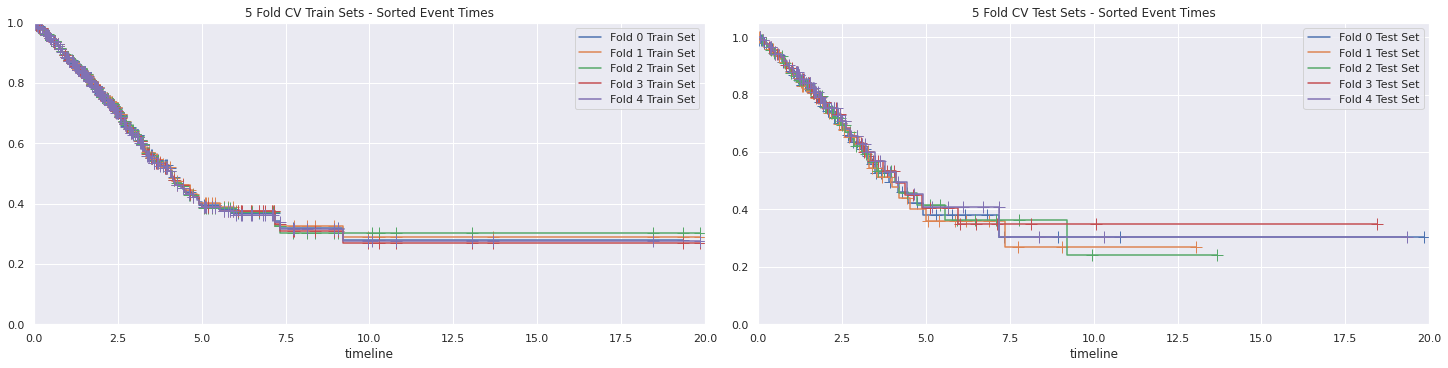

Running sanity check, this should return no samples!
All good

Running sanity check, this should return no samples!
All good



In [31]:
pickle_file = '%s/utilities/files/LUAD/overall_survival_TCGA_folds.pkl' % (main_path)
frame_all   = process_frame(frame=frame_ready, no_treatment=False, s1_stage=False)
folds       = get_folds_bins(frame=frame_all, eps=1e-6, num_folds=5)

# Survival fold.
# Pickle file for Cox regression: done by TCGA sample.
print_survival_folds(frame_all, folds)
flag_good = sanity_check_overlap(folds, num_folds=5)
if flag_good and not os.path.isfile(pickle_file):
    print('Saved pickle:', pickle_file)
    store_data(folds, pickle_file)

# DataFrame for metadata.
frame_all = frame_all.rename(columns={'case_submitter_id':'samples', 'event_ind':'os_event_ind', 'event_data':'os_event_data'})
frame_all = frame_all.merge(samples_frame, how='inner', left_on='samples', right_on='samples')[['samples', 'slides', 'os_event_ind', 'os_event_data']]
if flag_good and not os.path.isfile(pickle_file.replace('.pkl','.csv')):
    print('Saved CSV:', pickle_file.replace('.pkl','.csv'))
    frame_all.to_csv(pickle_file.replace('.pkl','.csv'), index=False)

# Clustering fold: using all available slides given the samples in the fold.
# Pickle file for clustering: done by TCGA slides, using all possible slides.
folds_slides = fold_samples_to_slides(folds, frame_all)
flag_good = sanity_check_overlap(folds_slides, num_folds=5)
if flag_good and not os.path.isfile(pickle_file.replace('.pkl','_slides.pkl')):
    print('Saved pickle:', pickle_file.replace('.pkl','_slides.pkl'))
    store_data(folds, pickle_file)


# Only Stage 1 samples - Experiment

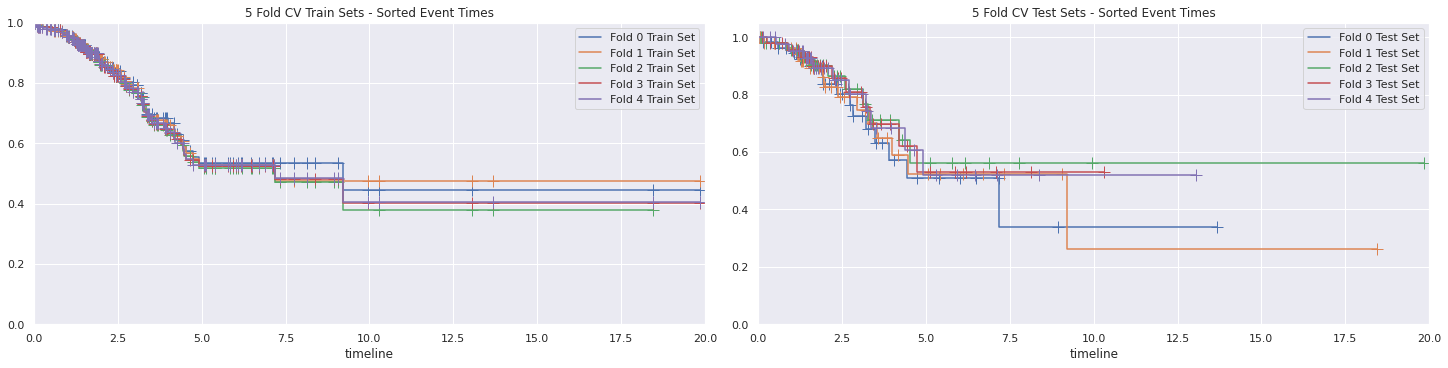

Running sanity check, this should return nothing!
All good


In [173]:
frame_s1 = process_frame(frame=frame_ready, no_treatment=False, s1_stage=True)
folds    = get_folds_bins(frame=frame_s1, eps=1e-6, num_folds=5)

print_survival_folds(frame_s1, folds)
flag_good = sanity_check_overlap(folds, num_folds=5)

# Pickle file for Cox regression: done by TCGA sample.
pickle_file   = '%s/utilities/files/LUAD/overall_survival_TCGA_s1_only_folds.pkl' % (main_path)
if flag_good and not os.path.isfile(pickle_file):
    print('Saved pickle:', pickle_file)
    store_data(folds, pickle_file)
